> Age열 추정

In [2]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn import model_selection, linear_model
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc
from sklearn import ensemble
from vecstack import StackingTransformer
from sklearn.svm import SVC, SVR
from sklearn import ensemble
from sklearn import cluster
from sklearn.metrics import silhouette_score
from sklearn.metrics import classification_report

from xgboost import XGBClassifier, plot_importance
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier 
from vecstack import stacking

<br>

## 1. Preparing dataset

In [4]:
data_df = pd.read_csv('titanic.csv')
data_df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


## Data info

- **PassengerId** : Unique ID of passenger
- **Survived** : 0 = No, 1 = Yes
- **pclass** : Ticket class (1 = 1st, 2 = 2nd, 3 = 3rd)
- **sibsp** : # of siblings & spouses aboard the Titanic
- **parch** : # of parents / children aboard the Titanic
- **ticket** : Ticket number
- **cabin** : Cabin number
- **embarked** : Port of Embarkation (C = Cherbourg, Q = Queenstown, S = Southampton)

In [5]:
y_data = data_df[['Survived']]
#x_data = data_df.copy()
y_data.head(3)

,Survived
0,0
1,1
2,1


In [6]:
# del data_df['Survived']
x_data = data_df.copy()
x_data.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


<br>

## 2. Feature engineering & Feature selection

#### 시도해볼 수 있는 전략들 by 강사님

- 불필요한 열이나 예측에 방해가 되는 열은 아예 지우기 (ex. PassengerId)
- 결측치 채우기 
- Text로 되어있는 Category(Factor)는 숫자로 바꿔주기 (ex. Male/Female -> 0/1)
- 실수 범위를 구간 범위로 바꿔주기 
- 필요한 경우 기존 열을 바탕으로 새로운 열을 계산해 추가하기

### 2.1. 전처리를 위한 Brainstorming
**우리팀에서 정한 전처리 내용** <br>
- embarked -> s로
- Cabin -> 자료 있음 1, 자료 없음 0
<br>

**우리팀에서 정한 Age열 다중회귀 방법** <br>
* 독립변수 : Pclass, Sex, SibSp, Parch, Fare, Cabin, Embarked
* Pclass : 1, 2, 3 ( 범주화 )
* Sex : male, female ( 1, 2 로 바꿔서 범주화 )
* SibSp : 1(1보다 크면), 0(0이면)  (범주화)
* Parch : 1(1보다 크면), 0(0이면)  (범주화)
* Fare : SipSp + Parch + 1 로 나눈 값 사용 ( Numeric )
* Cabin : 널 값 아니면 1, 널 값이면 0 (범주화)
* Embarked : 도시별 0, 1, 2 로 범주화 

**plus,** <br>
'Name'에서, Mr, Miss 등을 꺼내서 유의미한 정보를 가진 열을 만들어 줄 수 있을까

So, **Title을 봤을 때 다음과 같았음.**<br>
'Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms', <br>
'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess', <br>
'Jonkheer' <br>

1. Age 추정에는 대략적인 나잇대를 가늠할 수 있을 정도로만 묶어서 사용해보자.
    * 남성, 여성 성인 => 나이 많은 사람 '1'
    * 젊은 남성, 여성 => 젊은 사람 '2'
    * 귀족, 작위 => 미상(가늠 안됨) '3'
        <br> <br>
1. 그 사람의 지위(사회적 지위) 알 수 있어서, 이 열도 전체 분석 모델 Train 데이터에 추가하여 사용하는 것이 좋을 것 같다.
    * 명예직
    * 작위 소유 혹은 귀족
    * 일반
    <br>

### 2.2 x_data 변수 처리(수정, string -> int 변경 등)

In [7]:
title_simple_dict = {1:['Mr', 'Mrs','Don','Rev','Dr', 'Mme', 'Ms','Major','Sir','Col', 'Capt'], #남성, 여성, 명예직
              2:['Miss','Master','Lady','Mlle',], #젊은남성, 젊은여성
              3:['the Countess','Jonkheer']} #기타: 귀족,작위

title_hier_dict = {1:['Rev','Dr','Major','Sir','Col', 'Capt'], #명예직
                   2:['the Countess','Jonkheer'], #귀족, 작위
                   3:['Miss','Master','Lady','Mlle','Mr', 'Mrs','Don', 'Mme', 'Ms']} #일반

# Sex 범주화하기(0, 1)
x_data['Sex'] = x_data['Sex'].replace(['male', 'female'], [0, 1])

# Name에서 Title 열 만들기
x_data['Title'] = x_data['Name'].apply(lambda x: x.split(",")[1].split(".")[0].strip())

# Name에서 agebound 열 만들기
def give_agebound(x):
    for key, value in title_simple_dict.items():
        for title in value:
            x == title
            return key
x_data['agebound'] = x_data['Title'].apply(lambda x: give_agebound(x))

# Name에서 social_status 열 만들기
def give_socialstatus(x):
    for key, value in title_hier_dict.items():
        for title in value:
            x == title
            return key
x_data['socialstatus'] = x_data['Title'].apply(lambda x: give_socialstatus(x))

# Fare 1인당 가격으로 변경
x_data['Fare_edited'] = x_data['Fare']/(x_data['SibSp']+x_data['Parch']+1)

# SibSp 범주화하기(1 if Sibsp > =1 , else 0) 
x_data['SibSp_edited'] = x_data['SibSp'].apply(lambda x : 1 if x >= 1 else 0 )

# Parch 범주화하기(1 if Sibsp > =1 , else 0) 
x_data['Parch_edited'] = x_data['Parch'].apply(lambda x : 1 if x >= 1 else 0 )

# Embarked 도시별 0 = S, 1 = C , 2 = Q, 결측치는 0("S")로
embarked_dict = {"S":1, "C":2, "Q":3}
x_data['Embarked'] = x_data['Embarked'].apply(lambda x: embarked_dict.get(x, 0))

# Cabin 범주화(자료 있음 = 1, 자료 없음 = 0)
x_data.loc[x_data['Cabin'].notnull(), 'Cabin'] = 1
x_data.loc[x_data['Cabin'].isnull(), 'Cabin'] = 0

# 새로 생긴 feature들 위치 옮겨주기
print(len(x_data.columns))
print(x_data.columns)
x_data = x_data.reindex(columns = ['PassengerId', 'Survived', 'Pclass','Title','Name', 'agebound','socialstatus', 'Sex', 'Age', 'SibSp',
       'Parch','SibSp_edited', 'Parch_edited', 'Ticket', 'Fare', 'Fare_edited', 'Cabin', 'Embarked'])
print(len(x_data.columns))
print(x_data.columns)

# 마지막으로 Ticket 지우기
#del x_data['Survived'] #추후 age 추정 때 머징 위해 살림.
#del x_data['PassengerId']  #추후 age 추정 때 머징 위해 살림.
del x_data['Ticket']

print("\n=========================\n")
print(x_data.info())

18
Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Title', 'agebound',
       'socialstatus', 'Fare_edited', 'SibSp_edited', 'Parch_edited'],
      dtype='object')
18
Index(['PassengerId', 'Survived', 'Pclass', 'Title', 'Name', 'agebound',
       'socialstatus', 'Sex', 'Age', 'SibSp', 'Parch', 'SibSp_edited',
       'Parch_edited', 'Ticket', 'Fare', 'Fare_edited', 'Cabin', 'Embarked'],
      dtype='object')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   891 non-null    int64  
 1   Survived      891 non-null    int64  
 2   Pclass        891 non-null    int64  
 3   Title         891 non-null    object 
 4   Name          891 non-null    object 
 5   agebound      891 non-null    int64  
 6   socialstatus  891 non-null    int64  
 7   Sex    

## 3. Age 결측치 처리 => Regression 모델로 prediction
* 종속변수 : 'Age'
* 독립변수 목록
    * 'agebound','Pclass', 'Sex', 'SibSp_edited', 'Parch_edited', 'Fare_edited', 'Cabin','Embarked'


### 3.1 age_df 생성(독립변수, 종속변수만 모아서) 

In [8]:
# Age 전처리 위한 Age_df 생성
age_df = x_data.copy()

#독립변수, PassengerId, name와 종속변수만 남기기 ('agebound',Age','PassengerId','Name','Pclass', 'Sex', 'SibSp_edited', 'Parch_edited', 'Fare_edited', 'Cabin','Embarked')
age_df = age_df[['PassengerId','Name','Age','agebound','Pclass', 'Sex', 'SibSp_edited', 'Parch_edited', 'Fare_edited', 'Cabin','Embarked']]

age_notnull_df = age_df[age_df['Age'].notnull()]
age_isnull_df = age_df[age_df['Age'].isnull()]
del age_isnull_df['Age']

# age_data = np.array(age_notnull_df)
# age_isnull = np.array(age_isnull_df)

print(age_notnull_df.shape)
print(age_isnull_df.shape)

(714, 11)
(177, 10)


In [9]:
age_notnull_df.iloc[:,2:3]

,Age
0,22.0
1,38.0
2,26.0
3,35.0
4,35.0
...,...
885,39.0
886,27.0
887,19.0
889,26.0


### 3.2 train, validation split 하기
700개 다 넣고 gridsearch할 수도 있지만 (알아서 validation set해서 돌려줌) <br>
시간 제약으로 GredientBoostingRegressor를 사용하였고, <br>
수기로 파라메터 조정하면서 가장 나은 성능의 파라메터 찾음
<br>
<br>
그리고 age 값이 있는 데이터가 train, test 나누어 학습시키기에 <br>
양이 너무 적어서 age 값 있는 데이터 714개 모두 X_train, y_train으로 쓰기로 함.

In [10]:
# 데이터가 너무 적어서 전체를 X_train, y_train으로 쓰기로 함.

# train data, validation data split for age_data(notnull)
# from sklearn.model_selection import train_test_split

# #파이프라인 쓰려고 데이터프레임으로 넣었다.part5.추가학습자료 0413 수업 부분 확인
# X_train, X_test, y_train, y_test = train_test_split(age_notnull_df.iloc[:,3:],# X
#                                                     age_notnull_df.iloc[:,2:3], # Y
#                                                     test_size=0.1,
#                                                     random_state=0)

X_train = age_notnull_df.iloc[:,3:]
y_train = age_notnull_df.iloc[:,2:3]
print(X_train.shape) #$$$,8
print(y_train.shape)

(714, 8)
(714, 1)


### 3.3 Make Pipeline for feature-transformer(원핫인코딩만 사용)

In [11]:
list(age_notnull_df.columns)

['PassengerId',
 'Name',
 'Age',
 'agebound',
 'Pclass',
 'Sex',
 'SibSp_edited',
 'Parch_edited',
 'Fare_edited',
 'Cabin',
 'Embarked']

In [12]:
numeric_features = ['Fare_edited']
numeric_transformer = StandardScaler() # cf) RobustScaler

categorical_features = ['agebound',
                        'Pclass',
                        'Sex',
                         'SibSp_edited',
                         'Parch_edited',
                         'Cabin',
                         'Embarked']
categorical_transformer = OneHotEncoder(categories='auto',
                                       handle_unknown='ignore')

# preprocessor에서 특정 애들은 프리pass 시킬 수 없는가? ColumnTransformer 로 검색해서 찾을 수 있음.
# 방법은 ; ('pass_through', 'passthrough', numeric_features) 로 만들기

preprocessor =  ColumnTransformer(
    transformers=[ # List of (name, transformer, column(s))의 튜플들
        ('pass_through', 'passthrough', numeric_features),
        ('cat', categorical_transformer, categorical_features)])

### 3.4 프리프로세서, 데이터 피팅 with pipeline usage (processing only)

In [13]:
preprocessor_pipe = Pipeline(steps=[('preprocessor', preprocessor)]) 
preprocessor_pipe.fit(X_train) #전처리 도구들이 피팅된다

X_train_transformed = preprocessor_pipe.transform(X_train)

#이제 트랜스폼 된 애들로 학습시키고, 테스트

In [14]:
pd.DataFrame(X_train_transformed).head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,3.62500,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,35.64165,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,7.92500,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


### 3.5 GradientBoostingRegressor 모델 사용

In [15]:
# Fit regression model
params = {'n_estimators': 1000, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.05, 'loss': 'ls'}

model = GradientBoostingRegressor(**params, random_state=0)
model.fit(X_train_transformed, y_train) # <- x_train_transformed (not x_train)
model.predict(X_train_transformed)
print('MSE(Training data) w/ library: ', mean_squared_error(model.predict(X_train_transformed), y_train))
print('Square root of error(Training data)', np.sqrt(mean_squared_error(model.predict(X_train_transformed), y_train)))

# 회귀에서는 accuracy라는 개념이 없음 (지우기)
# accuracy = model.score(X_train_transformed, y_train)
# print("model score:", round(accuracy, 4))

MSE(Training data) w/ library:  65.8912560078688
Square root of error(Training data) 8.117342915503126


### 3.6 GradientBoostingRegressor - Age null 값 추정

In [16]:
# Age null 값 추정하기 => y_hat_test

# X_test df 준비
X_test = age_isnull_df.iloc[:,2:]

# preprocessor로 한번 돌리기
X_test_transformed = preprocessor_pipe.transform(X_test)
print(X_test_transformed.shape)

# predict X_test and save into a list
y_hat_test = model.predict(X_test_transformed)
print(y_hat_test.shape)

(177, 17)
(177,)


## 4. 결측치 y_hat_test 으로 채우고, <br> 전체 x_data로 다시 머지하기

In [17]:
# age_new_df로 다시 묶어주기
age_isnull_df['Age'] = y_hat_test
age_isnull_df.head()

age_new_df = pd.concat([age_notnull_df, age_isnull_df], axis=0)
age_new_df = age_new_df.sort_index()
#age_new_df.head(10)
#비교
#age_df.head(10)

In [18]:
# x_data에 보정된 age값 넣어주기
Age_edited = age_new_df['Age']
x_data['Age_edited']= Age_edited
list(x_data.columns)

['PassengerId',
 'Survived',
 'Pclass',
 'Title',
 'Name',
 'agebound',
 'socialstatus',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'SibSp_edited',
 'Parch_edited',
 'Fare',
 'Fare_edited',
 'Cabin',
 'Embarked',
 'Age_edited']

reindex 사용하여 x_data를 판다스로 보기 좋게, 열 순서 정리함

In [19]:
x_data = x_data.reindex(columns =['PassengerId',
 'Survived',
 'Pclass',
 'Title',
 'Name',
 'agebound',
 'socialstatus',
 'Sex',
 'Age',
 'Age_edited',
 'SibSp',
 'Parch',
 'SibSp_edited',
 'Parch_edited',
 'Fare',
 'Fare_edited',
 'Cabin',
 'Embarked'])

In [20]:
# id지우고 x_data csv 저장
del x_data['PassengerId']

x_data.to_csv('x_data_edited.csv', index= False)

print(x_data.info())
print(x_data.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Survived      891 non-null    int64  
 1   Pclass        891 non-null    int64  
 2   Title         891 non-null    object 
 3   Name          891 non-null    object 
 4   agebound      891 non-null    int64  
 5   socialstatus  891 non-null    int64  
 6   Sex           891 non-null    int64  
 7   Age           714 non-null    float64
 8   Age_edited    891 non-null    float64
 9   SibSp         891 non-null    int64  
 10  Parch         891 non-null    int64  
 11  SibSp_edited  891 non-null    int64  
 12  Parch_edited  891 non-null    int64  
 13  Fare          891 non-null    float64
 14  Fare_edited   891 non-null    float64
 15  Cabin         891 non-null    object 
 16  Embarked      891 non-null    int64  
dtypes: float64(4), int64(10), object(3)
memory usage: 118.5+ KB
None
   Survi

> titanic.csv 전처리 -> 공통 부분

In [21]:
data_df = pd.read_csv('titanic.csv')
data_df.head(3)
age_data = pd.read_csv('x_data_edited.csv') # Age_edited
age_data = age_data['Age_edited']

y_data = data_df[['Survived']]

del data_df['Survived']
x_data = data_df.copy()

del x_data['PassengerId']
del x_data['Ticket']
del x_data['Name']

x_data['Fare'] = x_data['Fare'] / (data_df['SibSp'] + data_df['Parch'] + 1)  # Fare 열 처리

x_data.loc[x_data['Sex'] == 'male', 'Sex'] = 1
x_data.loc[x_data['Sex'] == 'female', 'Sex'] = 2

x_data.loc[x_data['SibSp'] >= 1, 'SibSp'] = 1
x_data.loc[x_data['Parch'] >= 1, 'Parch'] = 1

x_data.loc[x_data['Cabin'].notnull(), 'Cabin'] = 1
x_data.loc[x_data['Cabin'].isnull(), 'Cabin'] = 0

x_data.loc[x_data['Embarked'].isnull(), 'Embarked'] = 'S'

x_data.loc[x_data['Embarked'] == 'C', 'Embarked'] = 0
x_data.loc[x_data['Embarked'] == 'S', 'Embarked'] = 1
x_data.loc[x_data['Embarked'] == 'Q', 'Embarked'] = 2

x_data['solo'] = (x_data['SibSp'] == 0) & (x_data['Parch'] == 0)
x_data['solo'] = x_data['solo'].astype(int)

x_data.drop(['SibSp', 'Parch'], axis = 1, inplace = True)

In [22]:
x_data['Age'] = age_data

In [23]:
x_data

,Pclass,Sex,Age,Fare,Cabin,Embarked,solo
0,3,1,22.000000,3.62500,0,1,0
1,1,2,38.000000,35.64165,1,0,0
2,3,2,26.000000,7.92500,0,1,1
3,1,2,35.000000,26.55000,1,1,0
4,3,1,35.000000,8.05000,0,1,1
...,...,...,...,...,...,...,...
886,2,1,27.000000,13.00000,0,1,1
887,1,2,19.000000,30.00000,1,1,1
888,3,2,26.123693,5.86250,0,1,0
889,1,1,26.000000,30.00000,1,0,1


In [24]:
x_data.to_csv('Data_Age_fit2.csv')

In [25]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(x_data, 
                                                                    y_data, 
                                                                    test_size=0.2, 
                                                                    random_state=0)

In [26]:
numeric_features = ['Age', 'Fare']
numeric_transformer = StandardScaler() # cf) RobustScaler

categorical_features = ['Pclass', 'Sex', 'Cabin', 'Embarked', 'solo']
categorical_transformer = OneHotEncoder(categories='auto') # categories='auto' : just for ignoring warning messages

preprocessor = ColumnTransformer(
    transformers = [ ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])


# transformers=[
#         ('cat', categorical_transformer, categorical_features),
#         ('pass_through', 'passthrough', numeric_features)]

preprocessor_pipe = Pipeline(steps=[('preprocessor', preprocessor)])

preprocessor_pipe.fit(x_train)

x_train_transformed = preprocessor_pipe.transform(x_train)
x_test_transformed = preprocessor_pipe.transform(x_test)

# 데이터 정리 : [Pclass, Sex, Age, Fare, Cabin, Embarked, solo] :
# 1. 더미 변수는 숫자로 전처리됨
# 2. Age 열의 결측값은 이름 / 성으로 추정되었음.
# 3. Fare 열은 동시 탑승객 수로 나눠졌음.
# 4. 선실 열은 값이 있음 / 없음으로 나누어 졌음.
# 5. solo 열은 SibSp, Parch(열)의 '유무'로 나누어 졌음.

> 로지스틱 회귀

훈련 셋 Accuracy:  0.8033707865168539
테스트 셋 Accuracy:  0.8100558659217877
Roc_AUC :  0.8640316205533596


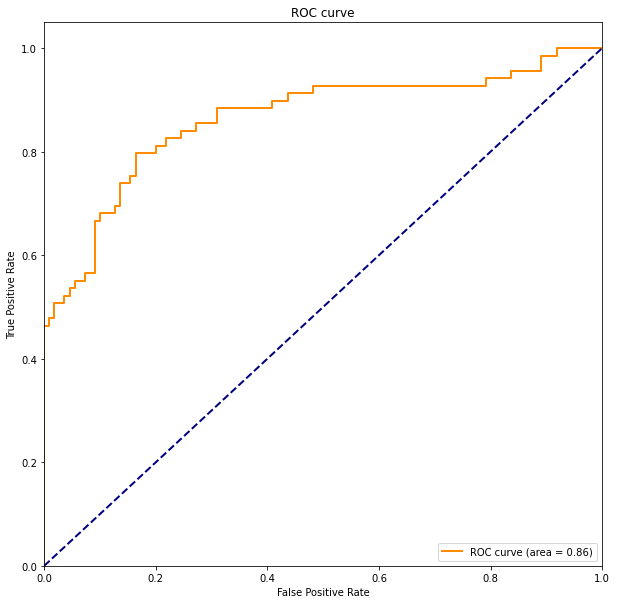

In [27]:
model_logistic = linear_model.LogisticRegression()

model_logistic.fit(x_train_transformed, y_train)

print('훈련 셋 Accuracy: ', accuracy_score(model_logistic.predict(x_train_transformed), y_train))
print('테스트 셋 Accuracy: ', accuracy_score(model_logistic.predict(x_test_transformed), y_test))

pred_train = model_logistic.predict_proba(x_test_transformed)

fpr, tpr, _ = roc_curve(y_true=y_test, y_score=pred_train[:,1])
roc_auc = auc(fpr, tpr)
print('Roc_AUC : ', roc_auc)    # 0.8640316205533596

plt.figure(figsize=(10, 10))

plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title("ROC curve")

plt.show()

# 디폴트 값으로 바로 넣어서 모델링 한것 -> 성능의 한계가 명확할 것이라는 직관으로 그냥 했음
# ROC_AUC : FPR 0 수준에서 TPR 0.5 정도 ... 또한 특정 구간에서의 TPR 성능이 아주 떨어짐

> K-means

In [28]:
x_train_for_k = x_train.copy()
x_test_for_k = x_test.copy()

x_train_for_k.drop('Embarked', axis = 1 , inplace = True)
x_test_for_k.drop('Embarked', axis = 1 , inplace = True)

In [29]:
kmeans = cluster.KMeans(n_clusters=2, random_state=0).fit(x_train_for_k) 
kmeans

KMeans(n_clusters=2, random_state=0)

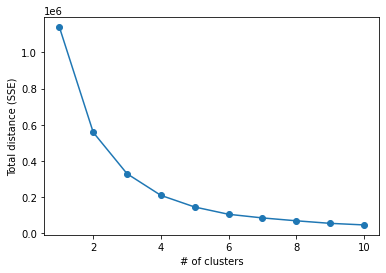

In [30]:
def elbow(X):
    total_distance = []
    for i in range(1, 11):
        model = cluster.KMeans(n_clusters=i, random_state=0)
        model.fit(X)
        
        # inertia : Sum of squared distances of samples to their closest cluster center.
        total_distance.append(model.inertia_) 
        
    plt.plot(range(1, 11), total_distance, marker='o')
    plt.xlabel('# of clusters')
    plt.ylabel('Total distance (SSE)')
    plt.show()

elbow(x_train_for_k)

In [31]:
y_fitted = kmeans.predict(x_train_for_k)

silhouette_avg = silhouette_score(x_train_for_k, y_fitted)

print("The average of silhouette coefficients is :", silhouette_avg)

print('accuracy score: ', accuracy_score(y_fitted, y_train))

The average of silhouette coefficients is : 0.8719553779142752
accuracy score:  0.625


In [32]:
# kmeans = cluster.KMeans(n_clusters=2, random_state=0).fit(t_X) 
# kmeans

y_fitted = kmeans.predict(x_test_for_k)

silhouette_avg = silhouette_score(x_test_for_k, y_fitted)

print("The average of silhouette coefficients is :", silhouette_avg)

print('accuracy score: ', accuracy_score(y_fitted, y_test))

The average of silhouette coefficients is : 0.8185895155595662
accuracy score:  0.6312849162011173


> GBM

In [33]:
params = {'n_estimators': 2500,
          'max_depth': 3,
          'min_samples_split': 5,
          'learning_rate': 0.01,
         'random_state':0}

model = GradientBoostingClassifier(**params)
model.fit(x_train_transformed, y_train)


print("Classification Report_Train")
print(classification_report(y_train, model.predict(x_train_transformed),target_names=['class 0', 'class 1']))

print("Classification Report_Test")
print(classification_report(y_test, model.predict(x_test_transformed),target_names=['class 0', 'class 1']))

print('Accuracy on Training set: ',accuracy_score(model.predict(x_train_transformed), y_train))
print('Accuracy on Test set: ', accuracy_score(model.predict(x_test_transformed),y_test))


# Accuracy on Training set:  0.9375780274656679
# Accuracy on Test set:  0.9



Classification Report_Train
              precision    recall  f1-score   support

     class 0       0.93      0.98      0.95       439
     class 1       0.96      0.89      0.92       273

    accuracy                           0.94       712
   macro avg       0.95      0.93      0.94       712
weighted avg       0.94      0.94      0.94       712

Classification Report_Test
              precision    recall  f1-score   support

     class 0       0.83      0.93      0.88       110
     class 1       0.86      0.70      0.77        69

    accuracy                           0.84       179
   macro avg       0.84      0.81      0.82       179
weighted avg       0.84      0.84      0.83       179

Accuracy on Training set:  0.9424157303370787
Accuracy on Test set:  0.8379888268156425


precision(정밀도) : 0.94
- 생존한다고 예측한 표본 중 실제 생존 표본 속하는 비율
recall(재현율) : 0.82
- 실제 생존한 표본 중에 생존한다고 예측한 표본의 수의 비율
accuracy
- train : 0.94
- test : 0.90

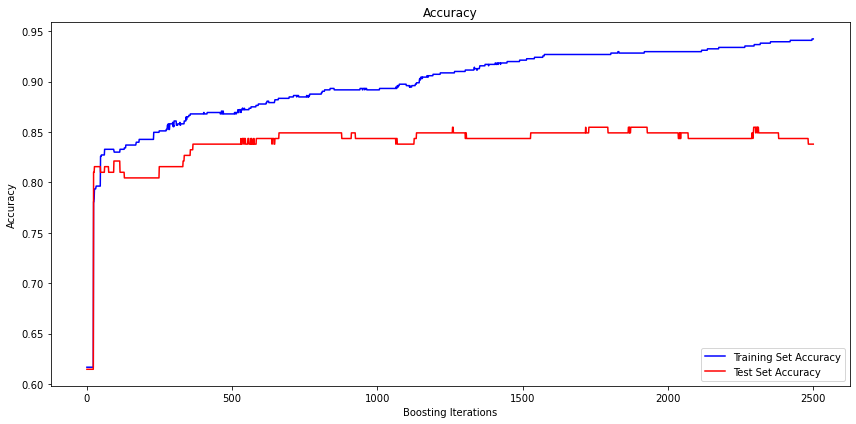

In [34]:
train_score = np.zeros((params['n_estimators'],), dtype=np.float64)
for i, y_pred in enumerate(model.staged_predict(x_train_transformed)):
    train_score[i] = accuracy_score(y_train, y_pred)

test_score = np.zeros((params['n_estimators'],), dtype=np.float64)
for i, y_pred in enumerate(model.staged_predict(x_test_transformed)):
    test_score[i] = accuracy_score(y_test, y_pred)
    
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 1, 1)
plt.title('Accuracy') # Binomial deviance loss function for binary classification
plt.plot(np.arange(params['n_estimators']) + 1, train_score, 'b-', label='Training Set Accuracy')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-', label='Test Set Accuracy')
plt.legend(loc='lower right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Accuracy')
fig.tight_layout()
plt.show()

roc_auc :  0.8792490118577075


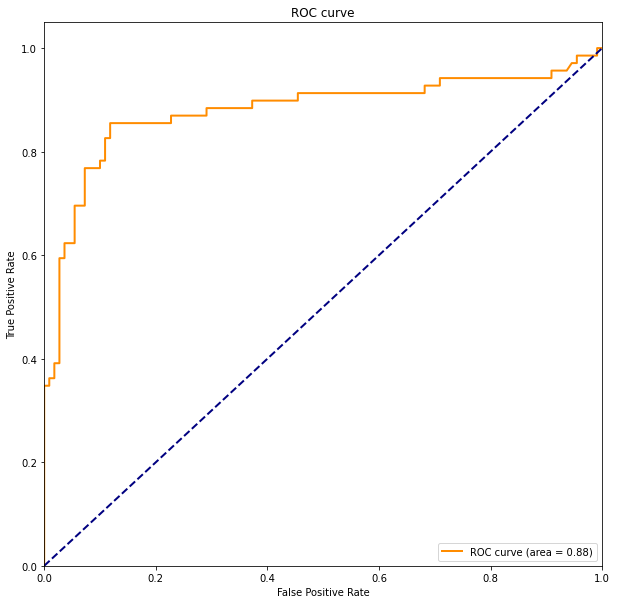

In [35]:
fpr, tpr, _ = roc_curve(y_true=y_test, y_score=model.predict_proba(x_test_transformed)[:,1])
roc_auc = auc(fpr, tpr) # AUC 면적의 값 (수치)
print('roc_auc : ', roc_auc)
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title("ROC curve")
plt.show()

In [37]:
param_grid = { "n_estimators": range(1000,2600,100), 
              "max_depth": [3], 
              "learning_rate": [0.001, 0.01],
              'min_samples_split': [3,5,10], 
              }

grid = GridSearchCV(model, param_grid, refit=True, verbose=2)

grid.fit(x_train_transformed, y_train)

print('The best parameters are ', grid.best_params_)

grid_predictions = grid.predict(x_test_transformed)
print(classification_report(y_test, grid_predictions))
print('Accuracy on Training set: ',accuracy_score(grid.predict(x_train_transformed), y_train))
print('Accuracy on Test set: ', accuracy_score(grid.predict(x_test_transformed),y_test))

fpr, tpr, _ = roc_curve(y_true=y_test, y_score=grid.predict_proba(x_test_transformed)[:,1]) # real y & predicted y (based on "Sepal width")
roc_auc = auc(fpr, tpr) # AUC 면적의 값 (수치)

plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title("ROC curve")
plt.show()

> SVM

In [38]:
df_na = pd.read_csv('x_data_edited.csv')

print(pd.isnull(df_na))
print(df_na.isnull().sum())
df_na.head(30)

standard_scaler = StandardScaler() 
#######
# 선빈님 csv
# df_sb = pd.read_csv('Data_Age_fit_survived.csv')
#######
# 나리님 csv
df_na = pd.read_csv('x_data_edited.csv')

train_data = df_na[['Pclass', 'agebound', 'socialstatus', 'Sex','Age_edited','SibSp_edited','Parch_edited','Fare_edited','Cabin','Embarked']]
#title, name, age, sibsp, parch, far 제외
target = df_na['Survived']

# 학습 , 평가 8 : 2
X_train, X_test, y_train, y_test = model_selection.train_test_split(train_data, target, test_size=0.2,random_state=0)

#스케일링,정규화
sc = StandardScaler() 
sc.fit(X_train) 
X_train_std=sc.transform(X_train) 
X_test_std=sc.transform(X_test) 
X_combined_std=np.vstack((X_train_std,X_test_std)) 
Y_combined_std=np.hstack((y_train,y_test))  
        
## 선형 커널 (선형 분리) 선형이므로 Cost와 gamma 파라미터가 없다.
# model=SVC(kernel='linear')  
                                                                # 스케일링 전 0.7877094972067039 
                                                                # 스케일링 후 0.7877094972067039

## 다항 커널
# model=SVC(kernel='poly', random_state=0,gamma=10,C=1) 
                                                                # 스케일링 전 : jupyter 1시간 지나도 무반응..
                                                                # 스케일링 후 0.8100558659217877

# ## 가우시안 커널 = RBF커널 (비선형 분리)
# model=SVC(kernel='rbf',random_state=0,gamma=0.001,C=100)
model=SVC(kernel='rbf',random_state=0,gamma=0.1,C=1)

                                                                # 스케일링 전 0.8100558659217877 
                                                                # 스케일링 후 0.7877094972067039
        
model.fit(X_train_std, y_train)
model.score(X_test_std, y_test)
accuracy = model.score(X_test_std,y_test)
print(accuracy)

#과거 데이터
# sb 0.6745230078563412
# + survived 0.6846240179573513
# + Age 0.6879910213243546

     Survived  Pclass  Title   Name  agebound  socialstatus    Sex    Age  \
0       False   False  False  False     False         False  False  False   
1       False   False  False  False     False         False  False  False   
2       False   False  False  False     False         False  False  False   
3       False   False  False  False     False         False  False  False   
4       False   False  False  False     False         False  False  False   
..        ...     ...    ...    ...       ...           ...    ...    ...   
886     False   False  False  False     False         False  False  False   
887     False   False  False  False     False         False  False  False   
888     False   False  False  False     False         False  False   True   
889     False   False  False  False     False         False  False  False   
890     False   False  False  False     False         False  False  False   

     Age_edited  SibSp  Parch  SibSp_edited  Parch_edited   Fare  Fare_edit

In [39]:
# 모델 성능 평가 지표, 혼동 행렬


from sklearn import metrics
from sklearn.metrics import classification_report

# 예측값 y_pred
y_pred= model.predict(X_test_std)
# print(y_pred)                # 10개 확인
# print(y_pred[0:10])         #[0 0 0 1 0 0 1 1 1 0] 
# print(y_test.values[0:10]) #[0 0 0 1 1 1 1 1 1 1] (7개 일치)

print(classification_report(y_test, y_pred))

svm_matrix = metrics.confusion_matrix(y_test, y_pred) 
print(svm_matrix)

              precision    recall  f1-score   support

           0       0.80      0.89      0.84       110
           1       0.79      0.65      0.71        69

    accuracy                           0.80       179
   macro avg       0.80      0.77      0.78       179
weighted avg       0.80      0.80      0.79       179

[[98 12]
 [24 45]]


### 평가 지표 해석
Precision : 정밀도 예측값 기준으로 정답인 예측값의 비율
Precision = TP/(TP + FP)

Recall : 재현율 실제값 기준으로 정답인 예측값의 비율
- Recall = TP/(TP+FN)

Accuracy : 정확도, 샘플 중 맞게 예측한 샘플 수의 비율
- Accuracy : (TP+TN) / all

F1-score : precision과 recall의 가중 조화평균 (단순평균 0.63 가중평균 0.66)
- F1 Score = 2*(Recall * Precision) / (Recall + Precision)

Support 각 라벨의 실제 샘플 수

Macro avg : 평균의 평균, 단순평균
- (normal+abnormal) /2 * precision or recall or f1 score

Weighted avg : 각 클래스에 속하는 표본의 개수로 가중 평균을 내서 계산하는 방법, 샘플 개수의 불균형을 고려
- weighted avg = normal/(normal+abnormal)  *  precision or recall or f1 score


In [40]:
# 혼동 행렬 해석

# [[96 14]
#  [20 49]]

# TP : 사망 분류                96명     실제 사망, 예측 결과 사망
# FP : 생존 - > 사망 오분류     20       실제 생존, 예측 결과 사망
# FN : 사망 -> 생존 오분류      14       실제 사망, 예측 결과 생존
# TN : 생존 분류                49       실제 생존, 예측 결과 생존

print(145 / 179)



0.8100558659217877


In [41]:
# 가우시안 커널 = RBF커널 (비선형 분리), SVM 모델 - SVC 
# Grid search : 최적의 하이퍼 파라미터 찾기

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
             'gamma': [0.001, 0.01, 0.1, 1, 10, 100] } #하이퍼파라미터 그리드를 담은 딕셔너리

grid_search = GridSearchCV(model, param_grid, cv=5, return_train_score=True)
# cv : C와 gamma 파라미터 쌍을 모델링할 때, train, test에 대해 진행할 교차 검증 횟수
# refit=True : 최적의 파라미터로 학습시킴
# return_train_score=True : 해당 매개변수는 훈련 폴드의 점수를 받을지 여부를 설정하는 변수.
# cross_val_score와 다르게 테스트 폴드 점수뿐 아니라 훈련 폴드에 대한 점수를 리턴 받을 수 있다.

grid_search.fit(X_train_std, y_train)
test_score = grid_search.score(X_test_std, y_test)

print("테스트 세트 점수: {:.2f}".format( test_score ))
print("최적 매개변수: {}".format(grid_search.best_params_))
print("최고 교차 검증 점수: {:.2f}".format(grid_search.best_score_))

테스트 세트 점수: 0.80
최적 매개변수: {'C': 1, 'gamma': 0.1}
최고 교차 검증 점수: 0.82


In [ ]:
# # SVC 데이터 확인을 위해 시각화 시도

# accuracy = round(model.score(train_data, target) * 100,2)
# print("Accuracy : ", accuracy, "%")
# from sklearn.datasets import make_circles
# import matplotlib.pyplot as plt
# # from matplotlib.pyplot import Color

# train_data, target = make_circles(factor=0.5, noise=0.1) # factor = R1/R2 , nosie :svd
# # print(train_data.shape,target)
# plt.scatter(train_data[:,0], train_data[:,1],c=target, cmap='coolwarm') #c = color cmap = colormap
# plt.colorbar(shrink=0.7)

In [ ]:
# # 파이프라인을 사용한 전처리 시도

# from sklearn.model_selection import train_test_split
# from sklearn.pipeline import Pipeline
# import numpy as np
# from sklearn.metrics import mean_squared_error
# from sklearn.impute import SimpleImputer


# # X_train, X_test, y_train, y_test = train_test_split(train_data, target, test_size=0.2, random_state=0)

# #StandardScaler 수치형 변수 스케일링 - Standardization 표준화

# # pipeline = Pipeline([ ('imputer', SimpleImputer(strategy="median")), ('attribs_adder', CombinedAttributesAdder()), ('std_scaler', StandardScaler()), ])
# pipeline = Pipeline([ ('imputer', SimpleImputer(strategy="median")), ('std_scaler', StandardScaler()), ])

# X_train = pipeline.fit_transform(X_train)



# # model.fit(X_train, y_train)
# # 모델 테스트세트 예측
# # X_test = pipeline.transform(X_test)
# # y_pred = model.predict(X_test)

# # 모델 평가: MSE, RMSE 평가 기준 값.
# # mse = mean_squared_error(y_test, y_pred)
# # rmse = np.sqrt(mse)


# # 파이프 라인 시도 2
# from sklearn.compose import ColumnTransformer
# from sklearn.pipeline import Pipeline

# num_pipeline = []
# cat_pipeline=()
# num_train = X_train.select_dtypes(include='number').columns.to_list()
# cat_train = X_train.select_dtypes(include='object').columns.to_list()
# preprocessor = ColumnTransformer(transformers=[('numeric', num_pipeline, num_train),
#                                               ('categorical', cat_pipeline, cat_train)],remainder='drop')

In [ ]:
# # pipeline try 3
# # columns 수치형, 범주화 조율 시도
# import seaborn as sns
# import matplotlib.pyplot as plt

# #수치형 : Age_edited, SibSp, Parch, SibSp_edited, Parch_edited
# #범주화 : Pcalss, Title(→socialstatus), Sex, Fare(Fare_edited), Cabin, Embarked, (agebound)
# #제외 : Name, Age(결측값 보존됨)


# # 연속,범주형 데이터 분류
# # conti = ['Fare','Age_edited','SibSp_edited', 'Parch_edited']
# # categ = ['Pclass','Title','socialstatus','Sex','Fare','Cabin','Embarked','agebound','SibSp', 'Parch',]
# # conti = [,','Parch_edited','socialstatus']
# # categ = ['',]SibSp_edited Parch_edited

# conti = ['Pclass','Sex','SibSp','Parch']
# categ = ['Fare','Age_edited','Embarked','Cabin']

# # 분포
# fig = plt.figure(figsize=(15,15))

# for i in range(0,len(categ)):
#     fig.add_subplot(3,3,i+1)
#     sns.countplot(x=categ[i], data=df_na)

# for col in conti:
#     fig.add_subplot(3,3,i+2)
#     sns.distplot(df_na[col].dropna());
#     i += 1
# plt.show()
# fig.clear()

In [ ]:
# ## 수치형 변수들 스케일링 해주기 - Standardization 표준화
# # 스케일링 시도
# from sklearn.datasets import load_iris
# from sklearn.preprocessing import StandardScaler
# from sklearn.svm import SVC
# standard_scaler = StandardScaler() 

# scale = StandardScaler().fit(df_na[['Fare','Age_edited']])
# df_na[['Fare','Age_edited','Embarked','Cabin']] = scale.transform(df_na[['Fare','Age_edited','Embarked','Cabin']])

# # 샘플링 (train.set / test.set)

# df_na

# target1 = df_na['Survived']
# train_data1 = df_na[['Pclass', 'agebound', 'socialstatus', 'Sex','Age_edited','SibSp_edited','Parch_edited','Fare_edited','Cabin','Embarked']]

# X_train, X_test, y_train, y_test = model_selection.train_test_split(train_data, target, test_size=0.2,random_state=0)
# #probability 확률
# model = SVC(probability = True)
# model.fit(X_train, y_train)
# y_pred = model1.predict(X_test)


# accuracy = model.score(X_test1,y_test)
# print("pipeline",accuracy) #0.7597765363128491 #conti = ['Pclass','Sex','SibSp','Parch','Embarked','Cabin'] categ = ['Fare','Age_edited']

> XGBOOST / Hyperopt

In [42]:
# !pip install xgboost==1.5.2
# !pip install vecstack==0.4.0
# !pip install hyperopt

from xgboost import XGBClassifier, plot_importance
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier 
from vecstack import stacking
import hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

In [49]:
# regularization candiate 정의
reg_candidate = [1e-5, 1e-4, 1e-3, 1e-2, 0.1, 1, 5, 10, 100]

# space 정의, Hyperparameter의 이름을 key 값으로 입력
space={'max_depth': hp.quniform("max_depth", 3, 8, 1),
       'learning_rate': hp.quniform ('learning_rate', 0.01, 0.011, 0.001),
       'reg_alpha' : hp.choice('reg_alpha', reg_candidate),
       'reg_lambda' : hp.choice('reg_lambda', reg_candidate),
       'subsample': hp.quniform('subsample', 0.6, 1, 0.05),
       'colsample_bytree' : hp.quniform('colsample_bytree', 0.6, 1, 0.05),
       'min_child_weight' : hp.quniform('min_child_weight', 1, 10, 1),
       'n_estimators': hp.quniform('n_estimators', 1000, 3000, 300)}

# 목적 함수 정의
# n_estimators, max_depth와 같은 반드시 int 타입을 가져야 하는 hyperparamter는 int로 타입 캐스팅 합니다.
def hyperparameter_tuning(space):
    model=XGBClassifier(n_estimators =int(space['n_estimators']), 
                       max_depth = int(space['max_depth']), 
                       learning_rate = space['learning_rate'],
                       reg_alpha = space['reg_alpha'],
                       reg_lambda = space['reg_lambda'],
                       subsample = space['subsample'],
                       colsample_bytree = space['colsample_bytree'], 
                       min_child_weight = int(space['min_child_weight']),
                       random_state=42,)
    
    evaluation = [(x_train_transformed, y_train), (x_test_transformed, y_test)]
    
    model.fit(x_train_transformed, y_train,
              eval_set=evaluation, 
              eval_metric='auc',
              verbose=0)

    accuracy = accuracy_score(model.predict(x_test_transformed), y_test)
    # 평가 방식 선정
    return {'loss': 1 - accuracy, 'status': STATUS_OK, 'model': model}    

In [52]:
# Trials 객체 선언합니다.
trials = Trials()
# best에 최적의 하이퍼 파라미터를 return 받습니다.
best = fmin(fn=hyperparameter_tuning,
            space=space,
            algo=tpe.suggest,
            max_evals=50, # 최대 반복 횟수를 지정합니다.
            trials=trials)

# 최적화된 결과를 int로 변환해야하는 파라미터는 타입 변환을 수행합니다.
best['max_depth'] = int(best['max_depth'])
best['min_child_weight'] = int(best['min_child_weight'])
best['n_estimators'] = int(best['n_estimators'])
best['reg_alpha'] = reg_candidate[int(best['reg_alpha'])]
best['reg_lambda'] = reg_candidate[int(best['reg_lambda'])]
print (best) # {'colsample_bytree': 0.9500000000000001, 'learning_rate': 0.01, 'max_depth': 9, 
            #'min_child_weight': 3, 'n_estimators': 1400, 'reg_alpha': 0.001, 'reg_lambda': 1e-05, 'subsample': 0.7000000000000001}

100%|███████████████████████████████████████████████| 50/50 [01:24<00:00,  1.70s/trial, best loss: 0.12290502793296088]
{'colsample_bytree': 0.8, 'learning_rate': 0.011, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 2400, 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 0.9500000000000001}


In [53]:
trials.best_trial['result']        # 나오는 모델값 ->

{'loss': 0.12290502793296088,
 'status': 'ok',
 'model': XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=0.8,
               enable_categorical=False, gamma=0, gpu_id=-1,
               importance_type=None, interaction_constraints='',
               learning_rate=0.011, max_delta_step=0, max_depth=6,
               min_child_weight=1, missing=nan, monotone_constraints='()',
               n_estimators=2400, n_jobs=8, num_parallel_tree=1,
               predictor='auto', random_state=42, reg_alpha=1, reg_lambda=1,
               scale_pos_weight=1, subsample=0.9500000000000001,
               tree_method='exact', validate_parameters=1, verbosity=None)}

In [44]:
xgb = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=0.8500000000000001,
               enable_categorical=False, gamma=0, gpu_id=-1,
               importance_type=None, interaction_constraints='',
               learning_rate=0.011, max_delta_step=0, max_depth=8,
               min_child_weight=4, monotone_constraints='()',
               n_estimators=3000, n_jobs=8, num_parallel_tree=1,
               predictor='auto', random_state=42, reg_alpha=0.1,
               reg_lambda=0.0001, scale_pos_weight=1, subsample=0.75,
               tree_method='exact', validate_parameters=1, verbosity=None)          # missing = nan 만 지우면 됨

evaluation = [(x_train_transformed, y_train), (x_test_transformed, y_test)]

xgb.fit(x_train_transformed, y_train, eval_set=evaluation, eval_metric='auc', verbose=0)

accuracy_score(xgb.predict(x_test_transformed), y_test)   

0.888268156424581

In [45]:
print("Classification Report_Train")
print(classification_report(y_train, xgb.predict(x_train_transformed),target_names=['class 0', 'class 1']))

print("Classification Report_Test")
print(classification_report(y_test, xgb.predict(x_test_transformed),target_names=['class 0', 'class 1']))

print('Accuracy on Training set: ',accuracy_score(xgb.predict(x_train_transformed), y_train))
print('Accuracy on Test set: ', accuracy_score(xgb.predict(x_test_transformed),y_test))

Classification Report_Train
              precision    recall  f1-score   support

     class 0       0.92      0.97      0.95       439
     class 1       0.94      0.87      0.91       273

    accuracy                           0.93       712
   macro avg       0.93      0.92      0.93       712
weighted avg       0.93      0.93      0.93       712

Classification Report_Test
              precision    recall  f1-score   support

     class 0       0.87      0.96      0.91       110
     class 1       0.93      0.77      0.84        69

    accuracy                           0.89       179
   macro avg       0.90      0.87      0.88       179
weighted avg       0.89      0.89      0.89       179

Accuracy on Training set:  0.9311797752808989
Accuracy on Test set:  0.888268156424581


> 앙상블 / 스택킹

In [46]:
from sklearn.ensemble import VotingClassifier

params = {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_split': 10, 'n_estimators': 1500}
model = GradientBoostingClassifier(**params)
model.fit(x_train_transformed, y_train)


estimators = [ 
    ('XGB', xgb),
    ('LightGBM', model),
    ('Logistic', model_logistic)]  

1. Stacking        -> 이미 XGBOOST / GredientBoost 에서 정확도 극대화 하려고 과적합 -> 성능 오히려 저하

In [47]:
stack = StackingTransformer(estimators, 
                            regression = False, 
                            metric = accuracy_score, 
                            n_folds = 5, stratified = True, shuffle = True, 
                            random_state = 0, verbose = 2)
stack = stack.fit(x_train_transformed, y_train)

S_train = stack.transform(x_train_transformed)
S_test = stack.transform(x_test_transformed)

model3 = XGBClassifier()
model3 = model3.fit(S_train, y_train) 

print('스태킹 기법을 사용한 accuracy : ', accuracy_score(y_train, model3.predict(S_train)))

task:         [classification]
n_classes:    [2]
metric:       [accuracy_score]
variant:      [A]
n_estimators: [3]

estimator  0: [XGB: XGBClassifier]
[14:09:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
    fold  0:  [0.81818182]
[14:09:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
    fold  1:  [0.79720280]
[14:09:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

2. Voting

In [48]:
# 개별모델을 소프트보팅 기반의 앙상블 모델로 구현한 분류기
voting_model = VotingClassifier(estimators=estimators, voting='soft')


# x_train_transformed_hash = hash(x_train_transformed)

# # 보팅 분류기의 학습/예측/평가
voting_model.fit(x_train_transformed, y_train)
pred = voting_model.predict(x_test_transformed)
print('보팅 분류기의 정확도: {0: .4f}'.format(accuracy_score(y_test, pred)))



[14:09:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
보팅 분류기의 정확도:  0.8659
